In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pybaseball import statcast
import seaborn as sns
import requests

In [5]:
# data = statcast('2025-07-01','2025-08-31')
# data.to_csv('data.csv', index=False)
# data = pd.read_csv('data.csv')

In [6]:
data = statcast('2025-03-01','2025-08-31')

This is a large query, it may take a moment to complete


c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


  1%|          | 1/170 [00:00<00:24,  6.94it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|          | 2/170 [00:00<00:59,  2.80it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▏         | 3/170 [00:00<00:50,  3.29it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postp

In [7]:
data = data[data['game_type']=='R']

In [8]:
data.reset_index(drop=True, inplace=True)

In [9]:
choice = data[data['description'].isin(['called_strike','ball'])].dropna(subset=['pitch_type','zone'])

In [10]:
games = choice['game_pk'].unique()

In [11]:
def find_hp_ump_idx(officals_lst):
    for i in range(len(officals_lst)):
        if 'Home Plate' in officals_lst[i].values():
            return i

In [12]:
def get_hp_ump_dct(games):
    game_ump_map = dict()

    for game in games:
        url = f'https://statsapi.mlb.com/api/v1/game/{game}/boxscore'
        r = requests.get(url, timeout=10).json()
        hp_ump_idx = 0
        misidx=0
        officials_values = r['officials'][hp_ump_idx].values()
        if 'Home Plate' not in officials_values:
            hp_ump_idx = find_hp_ump_idx(r['officials'])
            misidx+=1

        hp_ump = r['officials'][hp_ump_idx]
        hp_ump_id = hp_ump['official']['id']
        hp_ump_name = hp_ump['official']['fullName']

        game_ump_map[int(game)] = {'id': hp_ump_id, 'name': hp_ump_name}
    
    return game_ump_map

In [13]:
# game_ump_map = get_hp_ump_dct(games)

In [14]:
# ump_dct = {game_ump_map[game]['id']: game_ump_map[game]['name'] for game in game_ump_map}

In [15]:
# choice['ump_id'] = choice['game_pk'].apply(lambda x: game_ump_map[x]['id'])
# choice['ump_name'] = choice['game_pk'].apply(lambda x: game_ump_map[x]['name'])

In [16]:
def choice_df_maker(data):
    choice = data[data['description'].isin(['called_strike','ball'])].dropna(subset=['pitch_type','zone'])
    
    games = choice['game_pk'].unique()

    game_ump_map = get_hp_ump_dct(games)
    ump_dct = {game_ump_map[game]['id']: game_ump_map[game]['name'] for game in game_ump_map}

    choice['ump_id'] = choice['game_pk'].apply(lambda x: game_ump_map[x]['id'])
    choice['ump_name'] = choice['game_pk'].apply(lambda x: game_ump_map[x]['name'])

    return choice, ump_dct

In [17]:
choice, ump_dct = choice_df_maker(data)

In [18]:
choice

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,ump_id,ump_name
1,FF,2025-08-31,96.5,-2.37,5.08,"Iglesias, Raisel",681082,628452,NaN,called_strike,...,0.88,-0.88,22.4,<NA>,<NA>,<NA>,<NA>,<NA>,547380,Carlos Torres
2,SI,2025-08-31,95.6,-1.35,5.66,"Iglesias, Raisel",681082,628452,NaN,called_strike,...,1.46,-1.46,34.2,<NA>,<NA>,<NA>,<NA>,<NA>,547380,Carlos Torres
5,SI,2025-08-31,95.8,-2.37,5.14,"Iglesias, Raisel",664056,628452,NaN,called_strike,...,1.38,1.38,19.3,<NA>,<NA>,<NA>,<NA>,<NA>,547380,Carlos Torres
9,SI,2025-08-31,94.8,-1.27,5.82,"Iglesias, Raisel",592206,628452,NaN,called_strike,...,1.31,1.31,37.4,<NA>,<NA>,<NA>,<NA>,<NA>,547380,Carlos Torres
10,SI,2025-08-31,94.7,-1.25,5.78,"Iglesias, Raisel",592206,628452,NaN,ball,...,1.29,1.29,36.0,<NA>,<NA>,<NA>,<NA>,<NA>,547380,Carlos Torres
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600105,FF,2025-03-18,97.6,-1.69,5.55,"Yamamoto, Yoshinobu",664023,808967,NaN,ball,...,0.74,-0.74,45.3,<NA>,<NA>,<NA>,<NA>,<NA>,427344,Bill Miller
600106,FF,2025-03-18,97.3,-1.79,5.55,"Yamamoto, Yoshinobu",664023,808967,NaN,ball,...,0.8,-0.8,43.6,<NA>,<NA>,<NA>,<NA>,<NA>,427344,Bill Miller
600112,FS,2025-03-18,83.2,2.79,5.49,"Imanaga, Shota",669242,684007,NaN,ball,...,1.1,-1.1,37.8,<NA>,<NA>,<NA>,<NA>,<NA>,427344,Bill Miller
600114,SL,2025-03-18,83.1,2.88,5.31,"Imanaga, Shota",660271,684007,NaN,ball,...,-0.24,-0.24,31.0,<NA>,<NA>,<NA>,<NA>,<NA>,427344,Bill Miller


<Axes: xlabel='plate_x', ylabel='plate_z'>

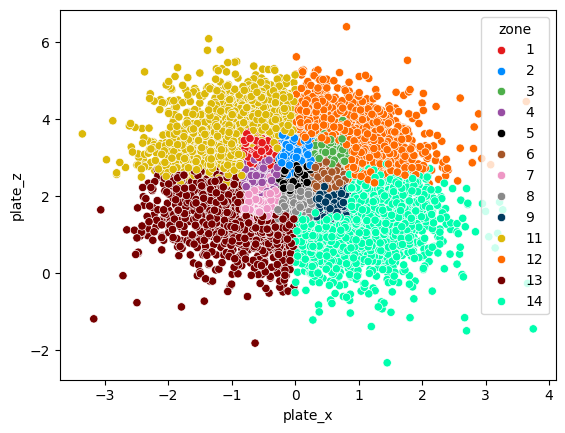

In [19]:
palette = {
    # strike zone 1–9 (distinct, non-blending)
    '1':  "#e41a1c",  # red
    '2':  "#008cff",  # blue
    '3':  "#4daf4a",  # green
    '4':  "#984ea3",  # purple
    '5':  "#000000",  # orange
    '6':  "#a65628",  # brown
    '7':  "#ee97c5",  # pink
    '8':  "#8A8A8A",  # gray
    '9':  "#003a5e",  # light blue

    # ball zones 11–14 (strong, warm tones)
    '11': "#dcb909",  # high - dark red
    '12': "#ff6a00",  # low - dark blue
    '13': "#760000",  # left - orange/red
    '14': "#00ffae",  # right - teal
}

hue_order = palette.keys()
sns.scatterplot(data=choice.assign(zone=choice['zone'].astype(int).astype(str)).sample(10000), x='plate_x',y='plate_z',hue='zone', palette=palette, hue_order=hue_order)

In [20]:
# df = choice[[
#     'game_date', 'ump_name', 'player_name', 'ump_id', 'pitch_type', 'p_throws', 'inning', 'balls', 'strikes',
#     'outs_when_up', 'pitcher','batter', 'stand', 'plate_x','plate_z','sz_top', 'sz_bot', 'zone', 'description',
# ]].copy()
# df['description'] = df['description'].map({'called_strike':'strike', 'ball':'ball'})
# df['balls'] = (df['balls'].astype(str) + '-' + df['strikes'].astype(str))
# df.loc[:, ['p_throws','stand']] = df[['p_throws','stand']] == 'R'
# df['game_date'] = pd.to_datetime(df['game_date'])

# df = df.rename(columns={'description':'call', 'balls':'count', 'p_throws':'pitcher_is_rhand', 'stand':'batter_is_rhand'}).drop(columns='strikes')
# df.head()

In [21]:
plate_half_width = (17/2)/12
ball_radius = (2.86/2)/12

In [22]:
def ball_or_strike(row):
    if -plate_half_width-ball_radius <= row['plate_x'] <= plate_half_width+ball_radius:
        szt_lim = row['sz_top'] + ball_radius
        szb_lim = row['sz_bot'] - ball_radius

        if szb_lim <= row['plate_z'] <= szt_lim:
            return 'strike'
    
    return 'ball'

In [23]:
def choice_df_preproc(choice_df):
    df = choice_df[[
        'game_date', 'ump_name', 'player_name', 'ump_id', 'pitch_type', 'p_throws', 'inning', 'balls', 'strikes',
        'outs_when_up', 'pitcher','batter', 'stand', 'plate_x','plate_z','sz_top', 'sz_bot', 'zone', 'description',
    ]].copy()
    
    df['description'] = df['description'].map({'called_strike':'strike', 'ball':'ball'})
    df['balls'] = (df['balls'].astype(str) + '-' + df['strikes'].astype(str))
    df.loc[:, ['p_throws','stand']] = df[['p_throws','stand']] == 'R'
    df['game_date'] = pd.to_datetime(df['game_date'])

    df['zone'] = df['zone'].astype(int)
    df['inning'] = df['inning'].astype(int)
    df['outs_when_up'] = df['outs_when_up'].astype(int)
    df['sz_top'] = df['sz_top'].astype(float)
    df['sz_bot'] = df['sz_bot'].astype(float)

    df = df.rename(columns={'description':'call', 'balls':'count', 'p_throws':'pitcher_is_rhand', 'stand':'batter_is_rhand'}).drop(columns='strikes')

    df['real'] = df.apply(ball_or_strike, axis=1)
    df['correct'] = df['call'] == df['real']
    df['incorrect'] = ~df['correct']

    return df

In [170]:
df = choice_df_preproc(choice)

,game_date,ump_name,player_name,ump_id,pitch_type,pitcher_is_rhand,inning,count,outs_when_up,pitcher,...,batter_is_rhand,plate_x,plate_z,sz_top,sz_bot,zone,call,real,correct,incorrect
93,2025-08-31,Carlos Torres,"Luzardo, Jesús",547380,ST,False,7,0-0,1,666200,...,True,0.44,1.77,3.25,1.55,9,strike,strike,True,False


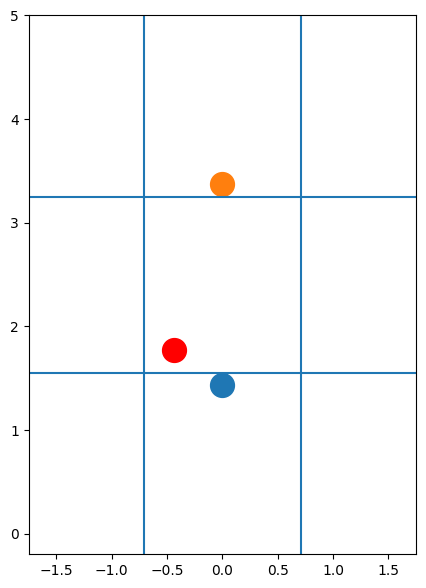

In [25]:
i = np.random.choice(len(df))
i = 46000
i = 21704
i = 46

plt.figure(figsize=(5,7))

szt_test = float(choice['sz_top'].iloc[i])
szb_test = float(choice['sz_bot'].iloc[i])

plt.axvline(-plate_half_width)
plt.axvline(plate_half_width)
plt.axhline(szt_test)
plt.axhline(szb_test)

xlims = 1.75
ylims = 1.75
plt.xlim(-xlims,xlims)
plt.ylim(szb_test-ylims,szt_test+ylims)

pitches_x = float(choice['plate_x'].iloc[i])
pitches_z = float(choice['plate_z'].iloc[i])
call = choice['description'].iloc[i]
color = 'red' if call == 'called_strike' else 'lightgreen'
plt.scatter(x=-pitches_x,y=pitches_z,c=color,s=(ball_radius*2*72)**2)
plt.scatter(x=0, y=szb_test-ball_radius,s=(ball_radius*2*72)**2)
plt.scatter(x=0, y=szt_test+ball_radius,s=(ball_radius*2*72)**2)

df.iloc[[i]]

In [172]:
df['real'] = df.apply(ball_or_strike, axis=1)
df['correct'] = df['call'] == df['real']
df['incorrect'] = ~df['correct']

In [ ]:
from ../abs_helper.abs_helper import ABSHelper

ModuleNotFoundError: No module named 'abs_helper'

In [27]:
df.groupby('ump_name')['correct'].mean().sort_values(ascending=False)

ump_name
Edwin Jimenez         0.946724
Mark Ripperger        0.941394
Derek Thomas          0.940638
Alan Porter           0.939698
Dan Merzel            0.938362
                        ...   
Laz Diaz              0.907376
Andy Fletcher         0.907039
Bruce Dreckman        0.902163
Hunter Wendelstedt    0.893519
Rob Drake             0.892779
Name: correct, Length: 92, dtype: float64

In [28]:
ump_zone_acc = df.groupby(['ump_id', 'zone'])['correct'].mean()#.sort_values(ascending=False)

In [29]:
ump_zone_acc

ump_id  zone
427013  1       0.716216
        2       0.847619
        3       0.761194
        4       0.952381
        5       1.000000
                  ...   
691042  9       0.890244
        11      0.987261
        12      0.959276
        13      0.973333
        14      0.978155
Name: correct, Length: 1196, dtype: float64

In [30]:
choice[choice['ump_id']==658325]['game_pk'].value_counts()

game_pk
776565    177
777072    108
Name: count, dtype: Int64

In [31]:
ump_zone_acc.loc[658325].sort_index()

zone
1     0.625000
2     0.833333
3     0.666667
4     1.000000
5     1.000000
6     0.857143
7     0.833333
8     0.800000
9     0.714286
11    0.939394
12    0.928571
13    0.931818
14    1.000000
Name: correct, dtype: float64

In [32]:
def make_ump_heatmap(ump_id=None, catcher_perspective=False):
    if ump_id == None:
        ump_id = np.random.choice(list(ump_dct.keys()))
    accs = np.array(ump_zone_acc.loc[ump_id][:9]).reshape(3,3)

    if catcher_perspective:
        accs = [lst[::-1] for lst in accs]

    sns.heatmap(accs, annot=True, cmap='bwr', vmin=.65, vmax=1)

    print(ump_dct[ump_id])
    return ump_zone_acc.loc[ump_id]

In [33]:
ump_acc_cnt = df.groupby('ump_name')['correct'].agg(['mean','count']).reset_index()
ump_acc_cnt

,ump_name,mean,count
0,Adam Beck,0.932530,3735
1,Adam Hamari,0.931373,3876
2,Adrian Johnson,0.918653,3860
3,Alan Porter,0.939698,3781
4,Alex MacKay,0.933930,3466
...,...,...,...
87,Tripp Gibson,0.928279,3416
88,Tyler Jones,0.908772,285
89,Vic Carapazza,0.923905,4087
90,Will Little,0.929554,3634


(array([ 2.,  1.,  3.,  8., 13., 22., 19., 15.,  7.,  2.]),
 array([0.89277899, 0.8981735 , 0.903568  , 0.9089625 , 0.91435701,
        0.91975151, 0.92514601, 0.93054051, 0.93593502, 0.94132952,
        0.94672402]),
 <BarContainer object of 10 artists>)

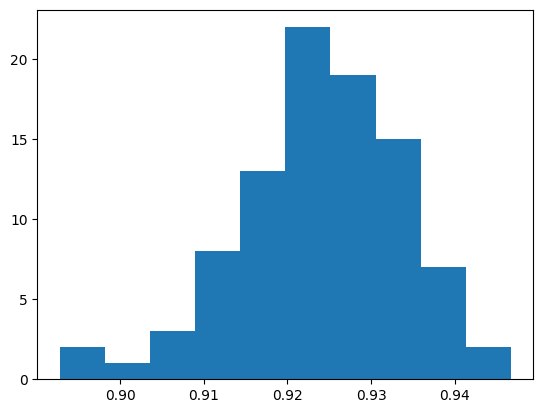

In [34]:
# umpire accuracy distribution

plt.hist(df.groupby('ump_name')['correct'].mean())

In [35]:
def z_test(row, lg_avg):
    p = row['mean']
    n = row['count']
    num = p - lg_avg
    denom = np.sqrt(
        lg_avg*(1-lg_avg) / n
    )
    return num / denom

In [36]:
lg_avg = df['correct'].mean()

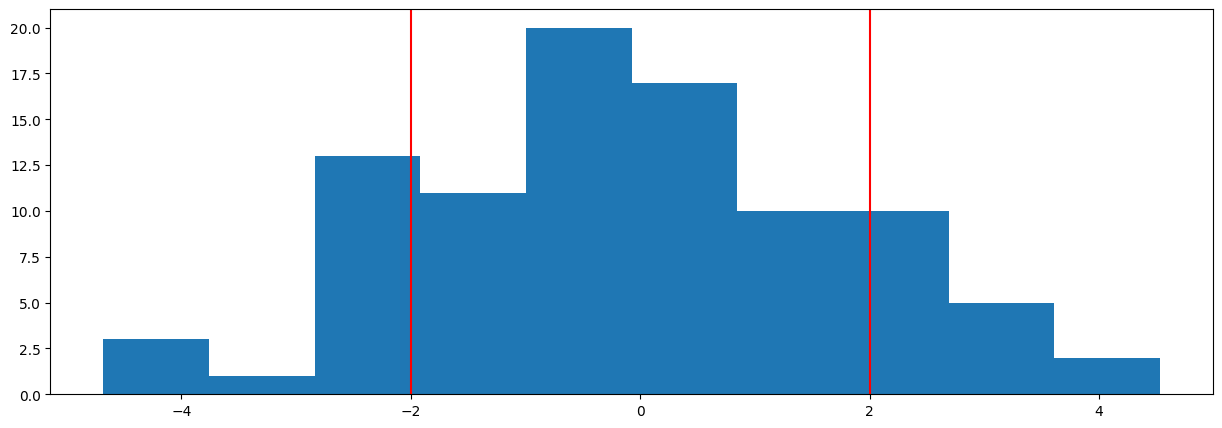

In [37]:
# normalized accuracy distribution showing significance cutoffs

plt.figure(figsize=(15,5))
plt.hist(ump_acc_cnt.apply(z_test, args=(lg_avg,), axis = 1))
plt.axvline(-2, c='red')
plt.axvline(2, c='red')

In [38]:
(ump_acc_cnt.apply(z_test, args=(lg_avg,), axis = 1).abs() >= 2).mean()

np.float64(0.32608695652173914)

In [39]:
def is_significant(row, lg_avg):
    p = row['mean']
    n = row['count']
    sims = np.random.binomial(n, lg_avg, 1000)/n
    p_val = (np.abs(sims - lg_avg) >= np.abs(p - lg_avg)).mean()
    # p_val = (sims <= p).mean()

    return bool(p_val <= .05)

In [40]:
ump_acc_cnt.apply(is_significant, args=(lg_avg,), axis=1).mean()

np.float64(0.32608695652173914)

In [41]:
from matplotlib.colors import TwoSlopeNorm

In [42]:
def make_ump_heatmap(ump_zone_acc, ump_id=None, catcher_perspective=False):
    if ump_id == None:
        ump_id = np.random.choice(list(ump_dct.keys()))

    zones = ump_zone_acc.loc[ump_id]
    small_idx = [1,2,3,4,5,6,7,8,9]
    big_idx   = [11,12,13,14]

    small = zones.reindex(small_idx).to_numpy().reshape(3,3)
    big   = zones.reindex(big_idx).to_numpy().reshape(2,2)

    # Center point for diverging colormap
    center = float(globals().get("lg_avg", np.nan))
    if not np.isfinite(center):
        center = float(np.nanmean(small))

    norm = TwoSlopeNorm(vmin=0.50, vcenter=center, vmax=1.00)

    fig, ax = plt.subplots(figsize=(7,7))

    # Geometry (centers aligned)
    pad = 0.35
    big_extent   = [-pad, 2+pad, -pad, 2+pad]
    small_extent = [0, 2, 0, 2]

    # Draw heatmaps
    ax.imshow(big,   extent=big_extent,   origin="upper", cmap="bwr", norm=norm)
    im = ax.imshow(small, extent=small_extent, origin="upper", cmap="bwr", norm=norm)

    # Borders
    ax.plot([big_extent[0], big_extent[1]], [big_extent[2], big_extent[2]], color="k")
    ax.plot([big_extent[0], big_extent[1]], [big_extent[3], big_extent[3]], color="k")
    ax.plot([big_extent[0], big_extent[0]], [big_extent[2], big_extent[3]], color="k")
    ax.plot([big_extent[1], big_extent[1]], [big_extent[2], big_extent[3]], color="k")
    for v in [0, 2/3, 4/3, 2]:
        ax.plot([v, v], [0, 2], color="k")
        ax.plot([0, 2], [v, v], color="k")

    # Labels for 1..9
    zone_nums = np.array(small_idx).reshape(3,3)
    cell_w, cell_h = 2/3, 2/3
    for r in range(3):
        for c in range(3):
            x_left  = c * cell_w
            x_c     = x_left + cell_w/2
            y_top   = 2 - r * cell_h
            y_c     = y_top - cell_h/2

            ax.text(x_left + 0.03, y_top - 0.03,
                    f"{zone_nums[r,c]}",
                    ha="left", va="top", fontsize=11, color="black")
            ax.text(x_c, y_c,
                    f"{small[r,c]:.0%}",
                    ha="center", va="center", fontsize=12, color="black")

    # Percentages for 11–14
    z11, z12, z13, z14 = zones.loc[11], zones.loc[12], zones.loc[13], zones.loc[14]
    tab_y_top, tab_y_bottom = 2 + pad/2, -pad/2
    ax.text(0.5,  tab_y_top,    f"{z11:.0%}", ha="center", va="center", fontsize=12)
    ax.text(1.5,  tab_y_top,    f"{z12:.0%}", ha="center", va="center", fontsize=12)
    ax.text(0.5,  tab_y_bottom, f"{z13:.0%}", ha="center", va="center", fontsize=12)
    ax.text(1.5,  tab_y_bottom, f"{z14:.0%}", ha="center", va="center", fontsize=12)

    # Small zone numbers for 11–14
    ax.text(big_extent[0]+0.04, big_extent[3]-0.04, "11", ha="left",  va="top",    fontsize=10)
    ax.text(big_extent[1]-0.04, big_extent[3]-0.04, "12", ha="right", va="top",    fontsize=10)
    ax.text(big_extent[0]+0.04, big_extent[2]+0.04, "13", ha="left",  va="bottom", fontsize=10)
    ax.text(big_extent[1]-0.04, big_extent[2]+0.04, "14", ha="right", va="bottom", fontsize=10)

    # Perspective flip
    if not catcher_perspective:
        ax.invert_xaxis()

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correct call rate", rotation=270, labelpad=14)
    cbar.set_ticks([0.5, center, 1.0])
    cbar.set_ticklabels([f"0.50", f"{center:.2f}", "1.00"])

    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    
    ump_name = ump_dct[ump_id]
    perspective = 'Catcher' if catcher_perspective else 'Pitcher'

    plt.title(f"{ump_name}'s Zone Accuracy - From {perspective}'s Perspective")
    plt.show()


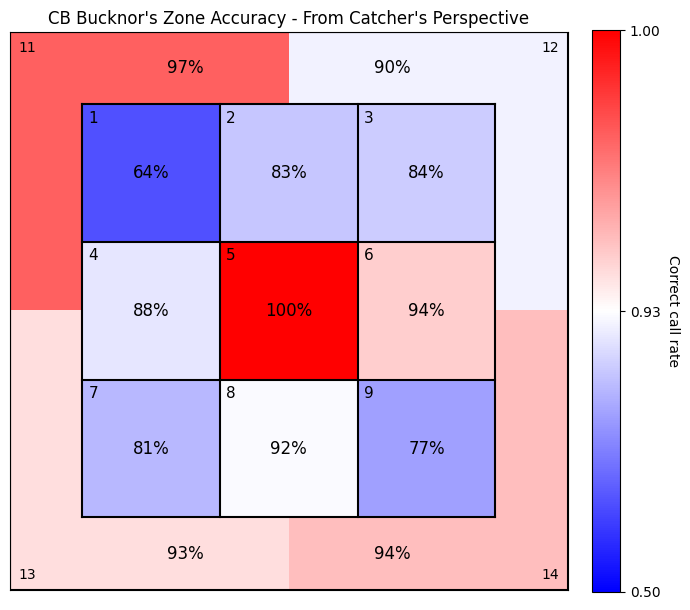

In [43]:
make_ump_heatmap(ump_zone_acc, 427044, True)

In [44]:
def make_ump_heatmap_avg(catcher_perspective=False):

    zones = df.groupby('zone')['correct'].mean()
    small_idx = [1,2,3,4,5,6,7,8,9]
    big_idx   = [11,12,13,14]

    small = zones.reindex(small_idx).to_numpy().reshape(3,3)
    big   = zones.reindex(big_idx).to_numpy().reshape(2,2)

    # Center point for diverging colormap
    center = float(globals().get("lg_avg", np.nan))
    if not np.isfinite(center):
        center = float(np.nanmean(small))

    norm = TwoSlopeNorm(vmin=0.50, vcenter=center, vmax=1.00)

    fig, ax = plt.subplots(figsize=(7,7))

    # Geometry (centers aligned)
    pad = 0.35
    big_extent   = [-pad, 2+pad, -pad, 2+pad]
    small_extent = [0, 2, 0, 2]

    # Draw heatmaps
    ax.imshow(big,   extent=big_extent,   origin="upper", cmap="bwr", norm=norm)
    im = ax.imshow(small, extent=small_extent, origin="upper", cmap="bwr", norm=norm)

    # Borders
    ax.plot([big_extent[0], big_extent[1]], [big_extent[2], big_extent[2]], color="k")
    ax.plot([big_extent[0], big_extent[1]], [big_extent[3], big_extent[3]], color="k")
    ax.plot([big_extent[0], big_extent[0]], [big_extent[2], big_extent[3]], color="k")
    ax.plot([big_extent[1], big_extent[1]], [big_extent[2], big_extent[3]], color="k")
    for v in [0, 2/3, 4/3, 2]:
        ax.plot([v, v], [0, 2], color="k")
        ax.plot([0, 2], [v, v], color="k")

    # Labels for 1..9
    zone_nums = np.array(small_idx).reshape(3,3)
    cell_w, cell_h = 2/3, 2/3
    for r in range(3):
        for c in range(3):
            x_left  = c * cell_w
            x_c     = x_left + cell_w/2
            y_top   = 2 - r * cell_h
            y_c     = y_top - cell_h/2

            ax.text(x_left + 0.03, y_top - 0.03,
                    f"{zone_nums[r,c]}",
                    ha="left", va="top", fontsize=11, color="black")
            ax.text(x_c, y_c,
                    f"{small[r,c]:.0%}",
                    ha="center", va="center", fontsize=12, color="black")

    # Percentages for 11–14
    z11, z12, z13, z14 = zones.loc[11], zones.loc[12], zones.loc[13], zones.loc[14]
    tab_y_top, tab_y_bottom = 2 + pad/2, -pad/2
    ax.text(0.5,  tab_y_top,    f"{z11:.0%}", ha="center", va="center", fontsize=12)
    ax.text(1.5,  tab_y_top,    f"{z12:.0%}", ha="center", va="center", fontsize=12)
    ax.text(0.5,  tab_y_bottom, f"{z13:.0%}", ha="center", va="center", fontsize=12)
    ax.text(1.5,  tab_y_bottom, f"{z14:.0%}", ha="center", va="center", fontsize=12)

    # Small zone numbers for 11–14
    ax.text(big_extent[0]+0.04, big_extent[3]-0.04, "11", ha="left",  va="top",    fontsize=10)
    ax.text(big_extent[1]-0.04, big_extent[3]-0.04, "12", ha="right", va="top",    fontsize=10)
    ax.text(big_extent[0]+0.04, big_extent[2]+0.04, "13", ha="left",  va="bottom", fontsize=10)
    ax.text(big_extent[1]-0.04, big_extent[2]+0.04, "14", ha="right", va="bottom", fontsize=10)

    # Perspective flip
    if not catcher_perspective:
        ax.invert_xaxis()

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correct call rate", rotation=270, labelpad=14)
    cbar.set_ticks([0.5, center, 1.0])
    cbar.set_ticklabels([f"0.50", f"{center:.2f}", "1.00"])

    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    
    ump_name = 'League Average'
    perspective = 'Catcher' if catcher_perspective else 'Pitcher'

    plt.title(f"{ump_name}'s Zone Accuracy - From {perspective}'s Perspective")
    plt.show()


In [45]:
ump_zone_acc.reset_index().query('zone==1').sort_values('correct', ascending=False)

,ump_id,zone,correct
728,573597,1,0.861538
442,483919,1,0.858209
936,621660,1,0.844828
182,427344,1,0.837838
91,427139,1,0.825758
...,...,...,...
247,427554,1,0.572464
507,486200,1,0.571429
234,427537,1,0.550000
1144,668921,1,0.500000


In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, make_scorer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.stats import randint, loguniform, uniform
from sklearn.metrics import f1_score, confusion_matrix, classification_report, brier_score_loss, average_precision_score
import joblib

In [47]:
target = "incorrect"

cat_cols = ["ump_id", "pitch_type", "count", "zone", "inning"]
num_cols = ["outs_when_up", "pitcher_is_rhand", "batter_is_rhand", "sz_top", "sz_bot"]
feature_cols = cat_cols + num_cols

# Ensure datetime sort
df = df.sort_values("game_date")#.reset_index(drop=True)

X_all = df[feature_cols].copy()
y_all = df[target].astype(int).values

# Hold-out test split by time (e.g., last 20% as test)
cut = int(len(df) * 0.75)
X_train, y_train = X_all.iloc[:cut], y_all[:cut]
X_test,  y_test  = X_all.iloc[cut:],  y_all[cut:]


In [48]:
# # -----------------------------
# # 0) Columns & basic prep
# # -----------------------------

# # -----------------------------
# # 1) Preprocessor
# # -----------------------------
# preproc = ColumnTransformer(
#     transformers=[
#         ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
#         ("num", "passthrough", num_cols),
#     ]
# )

# # -----------------------------
# # 2A) PIPELINE: Logistic Regression (ridge)
# # -----------------------------
# # logreg_pipe = Pipeline([
# #     ("prep", preproc),
# #     ("clf", LogisticRegression(
# #         solver="lbfgs",
# #         max_iter=2000,
# #         penalty="l2",
# #     ))
# # ])

# # logreg_param_dist = {
# #     "clf__C": np.logspace(-3, 2, 20),
# # }

# # -----------------------------
# # 2B) PIPELINE: XGBoost
# # -----------------------------
# xgb_pipe = Pipeline([
#     ("prep", preproc),
#     ("clf", XGBClassifier(
#         objective="binary:logistic",
#         eval_metric="logloss",
#         tree_method="hist",       # use 'gpu_hist' if you have GPU
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

# # calculating values for scale position weight
# pos_ratio = y_train.mean()
# neg_ratio = 1 - pos_ratio
# spw = neg_ratio / pos_ratio

# xgb_param_dist = {
#     "clf__n_estimators": [200, 300, 400, 600, 800],
#     "clf__max_depth": [3, 4, 5, 6],
#     "clf__learning_rate": [0.02, 0.03, 0.05, 0.08, 0.1],
#     "clf__subsample": [0.7, 0.8, 0.9, 1.0],
#     "clf__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
#     "clf__reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
#     "clf__reg_alpha": [0.0, 0.1, 0.5, 1.0],
#     "clf__scale_pos_weight": [1.0, spw * 0.5, spw, spw * 1.5, spw * 2.0]
# }

# # -----------------------------
# # 3) Time-based CV & Search (train split only)
# # -----------------------------
# # Rolling/forward-chaining CV that respects time order
# tscv = TimeSeriesSplit(n_splits=5)

# scorer_auc = "roc_auc"
# scorer_logloss = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

# # logreg_search = RandomizedSearchCV(
# #     estimator=logreg_pipe,
# #     param_distributions=logreg_param_dist,
# #     n_iter=20,
# #     scoring=scorer_auc,      # or scorer_logloss
# #     cv=tscv,
# #     n_jobs=-1,
# #     verbose=1,
# #     # random_state=42
# # )
# # logreg_search.fit(X_train, y_train)

# scoring = {
#     "roc_auc": "roc_auc",
#     "neg_log_loss": "neg_log_loss",
#     "ap": "average_precision",
#     "f1": make_scorer(f1_score, average="binary")
# }

# xgb_search = RandomizedSearchCV(
#     estimator=xgb_pipe,
#     param_distributions=xgb_param_dist,
#     n_iter=40,
#     scoring=scoring,      # or scorer_logloss
#     refit='roc_auc',
#     cv=tscv,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
# xgb_search.fit(X_train, y_train)

# # print("LOGREG best AUC (CV):", logreg_search.best_score_)
# # print("LOGREG best params:", logreg_search.best_params_)
# print("XGB    best AUC (CV):", xgb_search.best_score_)
# print("XGB    best params:", xgb_search.best_params_)

# # Pick the winner by CV score
# # best_search = xgb_search if xgb_search.best_score_ >= logreg_search.best_score_ else logreg_search
# # best_model = best_search.best_estimator_

# # -----------------------------
# # 4) Final evaluation on time-held-out test set
# # -----------------------------
# # probs = xgb_search.predict_proba(X_test)[:, 1]
# # print("TIME TEST AUC:", roc_auc_score(y_test, probs))
# # print("TIME TEST logloss:", log_loss(y_test, probs))

# # -----------------------------
# # 5) Fit on full training (optional already done by best_estimator_) and use on future games
# # -----------------------------
# # preds_future = best_model.predict_proba(new_df[feature_cols])[:, 1]


In [49]:
# joblib.dump(xgb_search, 'missed_call_model.pkl')

In [52]:
missed_call_model = joblib.load('missed_call_model.pkl')

In [53]:
probs = missed_call_model.predict_proba(X_test)[:, 1]
print("TIME TEST AUC:", roc_auc_score(y_test, probs))

TIME TEST AUC: 0.7772276209823077


In [54]:
preds = missed_call_model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     69132
           1       0.26      0.40      0.31      5647

    accuracy                           0.87     74779
   macro avg       0.60      0.65      0.62     74779
weighted avg       0.90      0.87      0.88     74779



In [55]:
probs.mean()

np.float32(0.27790993)

In [56]:
metrics = ["roc_auc", "neg_log_loss", "ap", "f1"]

cv = pd.DataFrame(missed_call_model.cv_results_)


summary = {}
for metric in metrics:
    summary[metric] = {
        "mean": cv[f"mean_test_{metric}"].mean(),
        "std": cv[f"mean_test_{metric}"].std(),
        "best_score": cv[f"mean_test_{metric}"].max(),
        "worst_score": cv[f"mean_test_{metric}"].min()
    }

summary_df = pd.DataFrame(summary).T
print(summary_df)

                  mean       std  best_score  worst_score
roc_auc       0.757732  0.007834    0.769964     0.737516
neg_log_loss -0.519027  0.206067   -0.228855    -0.874965
ap            0.222298  0.008020    0.237454     0.205684
f1            0.210021  0.094165    0.300196     0.002175


In [57]:
# best_params = missed_call_model.best_params_
# # narrow_param_dist = {
# #     # ±100 around best (keep integers)
# #     "clf__n_estimators": randint(best_params["clf__n_estimators"] - 100,
# #                                  best_params["clf__n_estimators"] + 100),

# #     # small integer wiggle around depth
# #     "clf__max_depth": randint(best_params["clf__max_depth"] - 1,
# #                               best_params["clf__max_depth"] + 2),

# #     # 20% margin, log-uniform so smaller rates get explored properly
# #     "clf__learning_rate": loguniform(best_params["clf__learning_rate"] * 0.8,
# #                                      best_params["clf__learning_rate"] * 1.2),

# #     # bounded between 0 and 1
# #     "clf__subsample": uniform(
# #         max(0.05, best_params["clf__subsample"] - 0.1), 0.2
# #     ),

# #     "clf__colsample_bytree": uniform(
# #         max(0.05, best_params["clf__colsample_bytree"] - 0.1), 0.2
# #     ),

# #     # regularization usually varies by factor of 2
# #     "clf__reg_lambda": loguniform(best_params["clf__reg_lambda"] * 0.5,
# #                                   best_params["clf__reg_lambda"] * 2.0),

# #     "clf__reg_alpha": loguniform(best_params["clf__reg_alpha"] * 0.5,
# #                                  best_params["clf__reg_alpha"] * 2.0),

# #     # class imbalance weight — ±30% margin
# #     "clf__scale_pos_weight": loguniform(best_params["clf__scale_pos_weight"] * 0.7,
# #                                         best_params["clf__scale_pos_weight"] * 1.3),
# # }

# ne_lo = max(50, best_params["clf__n_estimators"] - 100)
# ne_hi = max(ne_lo + 1, best_params["clf__n_estimators"] + 100)

# md_lo = max(1, best_params["clf__max_depth"] - 1)
# md_hi = max(md_lo + 1, best_params["clf__max_depth"] + 2)

# lr_lo = max(1e-4, best_params["clf__learning_rate"] * 0.8)
# lr_hi = max(lr_lo * 1.01, best_params["clf__learning_rate"] * 1.2)

# ss_lo = max(0.05, best_params["clf__subsample"] - 0.1)
# ss_hi = min(1.0, best_params["clf__subsample"] + 0.1)

# cs_lo = max(0.05, best_params["clf__colsample_bytree"] - 0.1)
# cs_hi = min(1.0, best_params["clf__colsample_bytree"] + 0.1)

# rl_lo = max(1e-8, best_params["clf__reg_lambda"] * 0.5)
# rl_hi = max(rl_lo * 1.01, best_params["clf__reg_lambda"] * 2.0)

# reg_alpha_grid = [0.0] + list(np.logspace(-8, 0, num=9))  # 0 plus 1e-8..1.0


# spw_lo = max(1e-6, best_params["clf__scale_pos_weight"] * 0.7)
# spw_hi = max(spw_lo * 1.01, best_params["clf__scale_pos_weight"] * 1.3)

# narrow_param_dist = {
#     "clf__n_estimators": randint(ne_lo, ne_hi),                 # [low, high)
#     "clf__max_depth": randint(md_lo, md_hi),
#     "clf__learning_rate": loguniform(lr_lo, lr_hi),
#     "clf__subsample": uniform(ss_lo, max(1e-6, ss_hi - ss_lo)), # uniform(loc, scale)
#     "clf__colsample_bytree": uniform(cs_lo, max(1e-6, cs_hi - cs_lo)),
#     "clf__reg_lambda": loguniform(rl_lo, rl_hi),
#     # use either Option A (categorical list) or Option B (dist) for reg_alpha:
#     "clf__reg_alpha": reg_alpha_grid,
#     # "clf__reg_alpha": reg_alpha_dist,
#     "clf__scale_pos_weight": loguniform(spw_lo, spw_hi),
# }

# scoring = {
#     "roc_auc": "roc_auc",
#     "neg_log_loss": "neg_log_loss",
#     "ap": "average_precision",
#     "f1": make_scorer(f1_score, average="binary"),
# }

# xgb_search_narrow = RandomizedSearchCV(
#     estimator=xgb_pipe,
#     param_distributions=narrow_param_dist,
#     n_iter=80,                 # bump this for a tighter search
#     scoring=scoring,
#     refit="roc_auc",            # or "neg_log_loss"/"ap" if that’s your goal
#     cv=tscv,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42,            # for reproducibility
#     error_score="raise"         # optional: fail fast if a sample is invalid
# )
# xgb_search_narrow.fit(X_train, y_train)

# probs_narrow = xgb_search_narrow.predict_proba(X_test)[:,1]

# print("Refit metric (roc_auc):", xgb_search_narrow.best_score_)
# print("Best params:", xgb_search_narrow.best_params_)


In [58]:
# print(probs_narrow.mean())
# xgb_search_narrow.best_params_

In [59]:
# metrics = ["roc_auc", "neg_log_loss", "ap", "f1"]

# cv = pd.DataFrame(xgb_search_narrow.cv_results_)


# summary = {}
# for metric in metrics:
#     summary[metric] = {
#         "mean": cv[f"mean_test_{metric}"].mean(),
#         "std": cv[f"mean_test_{metric}"].std(),
#         "best_score": cv[f"mean_test_{metric}"].max(),
#         "worst_score": cv[f"mean_test_{metric}"].min()
#     }

# summary_df = pd.DataFrame(summary).T
# print(summary_df)

In [60]:
# best_model_narrow = xgb_search_narrow.best_estimator_
# probs_narrow = best_model_narrow.predict_proba(X_test)[:, 1]
# print("TIME TEST AUC:", roc_auc_score(y_test, probs))
# print("TIME TEST logloss:", log_loss(y_test, probs))

In [61]:
# probs_narrow.mean()

In [62]:
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

In [63]:
# # split off a small calibration slice from the end of TRAIN
# cut_cal = int(len(X_train) * 0.9)
# X_core, y_core = X_train.iloc[:cut_cal], y_train[:cut_cal]
# X_cal,  y_cal  = X_train.iloc[cut_cal:], y_train[cut_cal:]

# best_pipe = clone(missed_call_model)
# best_pipe.fit(X_core, y_core)

# calib_iso = CalibratedClassifierCV(best_pipe, method="isotonic")
# calib_iso.fit(X_cal, y_cal)

# probs_cal = calib_iso.predict_proba(X_test)[:,1]

In [64]:
# joblib.dump(calib_iso, 'missed_call_model_calib.pkl')

In [65]:
missed_call_model_calib = joblib.load('missed_call_model_calib.pkl')

In [66]:
probs_cal = missed_call_model_calib.predict_proba(X_test)[:,1]

In [67]:
probs_cal.std()

np.float64(0.06887566485227743)

In [68]:
print("Base rate:", y_test.mean())
print("Mean prob (cal):", probs_cal.mean())
print("Log loss (cal):", log_loss(y_test, probs_cal))
print("Brier   (cal):", brier_score_loss(y_test, probs_cal))
print("ROC-AUC (cal):", roc_auc_score(y_test, probs_cal))
print("PR-AUC  (cal):", average_precision_score(y_test, probs_cal))

Base rate: 0.07551585338129689
Mean prob (cal): 0.07355053562719548
Log loss (cal): 0.23755889033388752
Brier   (cal): 0.06466388332835395
ROC-AUC (cal): 0.7481515293676602
PR-AUC  (cal): 0.21610067271985356


In [69]:
ump_avg_probs = X_test.assign(probs=probs_cal).groupby('ump_id')[['probs']].mean().sort_values('probs').reset_index()
ump_avg_probs['ump_name'] = ump_avg_probs['ump_id'].map(ump_dct)
ump_avg_probs = ump_avg_probs.merge(ump_acc_cnt, on = 'ump_name')
ump_avg_probs['mean'] = 1-ump_avg_probs['mean']
ump_avg_probs['diff'] = ump_avg_probs.apply(lambda x: abs(x['probs'] - x['mean']), axis=1)

In [70]:
ump_avg_probs.sort_values('diff')

,ump_id,probs,ump_name,mean,count,diff
9,596740,0.066981,Jansen Visconti,0.066807,3787,0.000174
80,594151,0.079842,Ramon De Jesus,0.080043,3698,0.000201
62,482666,0.075592,D.J. Reyburn,0.075086,3476,0.000506
26,676580,0.072247,Steven Jaschinski,0.072893,439,0.000646
52,427139,0.074946,Doug Eddings,0.074286,3850,0.000660
...,...,...,...,...,...,...
70,427129,0.077289,Bruce Dreckman,0.097837,2913,0.020548
11,486200,0.067984,David Arrieta,0.088629,598,0.020644
63,664263,0.075804,Edwin Jimenez,0.053276,3022,0.022528
0,482620,0.053660,Chris Conroy,0.077712,3899,0.024052


In [71]:
test_probs = (X_test.assign(pc=probs_cal))
test_probs['p'] = probs
# test_probs['pn'] = probs_narrow
test_probs = test_probs.merge(df[['game_date','player_name', 'batter', 'ump_name','call','real','incorrect']+feature_cols])

In [72]:
test_probs[['pc','p']].describe()

,pc,p
count,74787.000000,74787.000000
mean,0.073557,0.277919
std,0.068888,0.171011
min,0.000000,0.001098
25%,0.030963,0.156584
50%,0.058704,0.251459
75%,0.083008,0.355616
max,0.807609,0.899031


## Create Win Probability Model

In [73]:
sorted_games = data.sort_values(['game_pk', 'inning', 'at_bat_number', 'pitch_number'])
games_scores = sorted_games.groupby('game_pk')[['post_away_score', 'post_home_score']].last()
games_scores['home_team_win'] = games_scores.apply(lambda x: x['post_home_score'] > x['post_away_score'], axis=1)

In [74]:
home_won_dict = games_scores['home_team_win'].to_dict()

In [75]:
wp_df = data[[
    'game_date', 'game_pk', 'away_team', 'home_team', 'inning_topbot', 'inning', 'at_bat_number', 'pitch_number',
    'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'balls', 'strikes',
    'away_score', 'home_score', 'post_away_score', 'post_home_score'
]].copy()

wp_df[['on_1b','on_2b','on_3b']] = wp_df[['on_1b','on_2b','on_3b']].notna().astype(int).astype(str)
wp_df['on_1b'] = wp_df[['on_1b','on_2b','on_3b']].sum(axis=1)

wp_df['team_bat_score_diff'] = np.where(wp_df['inning_topbot']=='Bot', wp_df['home_score']-wp_df['away_score'], wp_df['away_score']-wp_df['home_score'])

home_won_ser = data['game_pk'].map(home_won_dict)
wp_df['team_bat_won'] = np.where(data['inning_topbot']=='Bot', home_won_ser, ~home_won_ser)

wp_df.rename(columns={
    'on_1b': 'base_state'
}, inplace=True)

wp_df.drop(columns={
    'on_2b', 'on_3b'
}, inplace=True)

In [76]:
wp_df

,game_date,game_pk,away_team,home_team,inning_topbot,inning,at_bat_number,pitch_number,outs_when_up,base_state,balls,strikes,away_score,home_score,post_away_score,post_home_score,team_bat_score_diff,team_bat_won
0,2025-08-31,776522,ATL,PHI,Bot,9,73,3,2,000,0,2,3,1,3,1,-2,False
1,2025-08-31,776522,ATL,PHI,Bot,9,73,2,2,000,0,1,3,1,3,1,-2,False
2,2025-08-31,776522,ATL,PHI,Bot,9,73,1,2,000,0,0,3,1,3,1,-2,False
3,2025-08-31,776522,ATL,PHI,Bot,9,72,3,1,000,0,2,3,1,3,1,-2,False
4,2025-08-31,776522,ATL,PHI,Bot,9,72,2,1,000,0,1,3,1,3,1,-2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600111,2025-03-18,778563,LAD,CHC,Top,1,2,2,1,000,1,0,0,0,0,0,0,True
600112,2025-03-18,778563,LAD,CHC,Top,1,2,1,1,000,0,0,0,0,0,0,0,True
600113,2025-03-18,778563,LAD,CHC,Top,1,1,3,0,000,1,1,0,0,0,0,0,True
600114,2025-03-18,778563,LAD,CHC,Top,1,1,2,0,000,0,1,0,0,0,0,0,True


In [77]:
wp_num_cols = ['inning', 'outs_when_up', 'balls', 'strikes', 'team_bat_score_diff']
wp_cat_cols = ['inning_topbot', 'base_state']
wp_feat_cols = wp_num_cols + wp_cat_cols

wp_target = 'team_bat_won'

In [78]:
wp_train_games, wp_test_games = train_test_split(wp_df['game_pk'].unique())

In [79]:
wp_train_games, wp_test_games = train_test_split(wp_df['game_pk'].unique())

wp_train_df = wp_df[wp_df['game_pk'].isin(wp_train_games)]
wp_test_df = wp_df[wp_df['game_pk'].isin(wp_test_games)]

X_wp_train, X_wp_test, y_wp_train, y_wp_test = wp_train_df[wp_feat_cols], wp_test_df[wp_feat_cols], wp_train_df[wp_target], wp_test_df[wp_target]

In [80]:
wp_df[wp_df['game_pk'].isin(wp_test_games)]

,game_date,game_pk,away_team,home_team,inning_topbot,inning,at_bat_number,pitch_number,outs_when_up,base_state,balls,strikes,away_score,home_score,post_away_score,post_home_score,team_bat_score_diff,team_bat_won
4011,2025-08-31,776507,BAL,SF,Top,9,87,5,2,010,2,2,2,13,2,13,-11,False
4012,2025-08-31,776507,BAL,SF,Top,9,87,4,2,010,2,1,2,13,2,13,-11,False
4013,2025-08-31,776507,BAL,SF,Top,9,87,3,2,100,1,1,2,13,2,13,-11,False
4014,2025-08-31,776507,BAL,SF,Top,9,87,2,2,100,0,1,2,13,2,13,-11,False
4015,2025-08-31,776507,BAL,SF,Top,9,87,1,2,100,0,0,2,13,2,13,-11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595515,2025-03-27,778562,PIT,MIA,Top,1,1,5,0,000,2,2,0,0,0,0,0,False
595516,2025-03-27,778562,PIT,MIA,Top,1,1,4,0,000,2,1,0,0,0,0,0,False
595517,2025-03-27,778562,PIT,MIA,Top,1,1,3,0,000,2,0,0,0,0,0,0,False
595518,2025-03-27,778562,PIT,MIA,Top,1,1,2,0,000,1,0,0,0,0,0,0,False


In [81]:
X_wp_train, X_wp_test, y_wp_train, y_wp_test = train_test_split(wp_df[wp_feat_cols], wp_df[wp_target], test_size=.25)

In [82]:
wp_preproc = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), wp_cat_cols),
    ('num', 'passthrough', wp_num_cols)
])

In [83]:
wp_pipe = Pipeline([
    ('prep', wp_preproc),
    ('wp_clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    ))
])

In [84]:
wp_pipe.fit(X_wp_train, y_wp_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['inning_topbot',
                                                   'base_state']),
                                                 ('num', 'passthrough',
                                                  ['inning', 'outs_when_up',
                                                   'balls', 'strikes',
                                                   'team_bat_score_diff'])])),
                ('wp_clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_by...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [85]:
wp_preds = wp_pipe.predict(X_wp_test)

In [86]:
print(classification_report(y_wp_test, wp_preds))

              precision    recall  f1-score   support

       False       0.75      0.76      0.75     73000
        True       0.77      0.76      0.76     77029

    accuracy                           0.76    150029
   macro avg       0.76      0.76      0.76    150029
weighted avg       0.76      0.76      0.76    150029



In [87]:
from sklearn.model_selection import StratifiedGroupKFold

In [88]:
# wp_param_dist = {
#     "wp_clf__n_estimators": [200, 300, 400, 600, 800],
#     "wp_clf__max_depth": [3, 4, 5, 6],
#     "wp_clf__learning_rate": [0.02, 0.03, 0.05, 0.08, 0.1],
#     "wp_clf__subsample": [0.7, 0.8, 0.9, 1.0],
#     "wp_clf__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
#     "wp_clf__reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
#     "wp_clf__reg_alpha": [0.0, 0.1, 0.5, 1.0],
#     # "clf__scale_pos_weight": [1.0, spw * 0.5, spw, spw * 1.5, spw * 2.0]
# }


# scoring = {
#     "roc_auc": "roc_auc",
#     "neg_log_loss": "neg_log_loss",
#     "ap": "average_precision",
#     "f1": make_scorer(f1_score, average="binary")
# }

# groups = wp_df.loc[X_wp_train.index, 'game_pk'].values
# cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# wp_search = RandomizedSearchCV(
#     estimator=wp_pipe,
#     param_distributions=wp_param_dist,
#     n_iter=40,
#     scoring=scoring,      # or scorer_logloss
#     refit='roc_auc',
#     cv=cv,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
# wp_search.fit(X_wp_train, y_wp_train, groups=groups)

In [89]:
# joblib.dump(wp_search, 'wp_model.pkl')

In [90]:
wp_model = joblib.load('wp_model.pkl')

In [91]:
wp_search_preds = wp_model.predict(X_wp_test)

# print(classification_report(y_wp_test, wp_preds))
print(classification_report(y_wp_test, wp_search_preds))


              precision    recall  f1-score   support

       False       0.75      0.76      0.75     73000
        True       0.77      0.76      0.76     77029

    accuracy                           0.76    150029
   macro avg       0.76      0.76      0.76    150029
weighted avg       0.76      0.76      0.76    150029



In [92]:
wprobs = X_wp_test.assign(wp = wp_model.predict_proba(X_wp_test)[:, 1])
wprobs['won'] = y_wp_test

In [93]:
wprobs[
    (~wprobs['won'])
].sort_values('wp')

,inning,outs_when_up,balls,strikes,team_bat_score_diff,inning_topbot,base_state,wp,won
409076,9,2,1,0,-17,Top,000,9.573868e-07,False
130962,9,2,1,0,-10,Top,000,9.573868e-07,False
559238,9,2,0,0,-11,Top,000,9.637433e-07,False
370376,9,2,0,0,-13,Top,000,9.637433e-07,False
16872,9,2,0,0,-10,Top,000,9.637433e-07,False
...,...,...,...,...,...,...,...,...,...
328332,8,2,0,1,6,Bot,000,9.954475e-01,False
328341,8,0,0,2,5,Bot,010,9.967538e-01,False
328340,8,0,1,2,5,Bot,010,9.968172e-01,False
328336,8,0,2,1,6,Bot,100,9.970770e-01,False


In [94]:
merged = wp_df.drop(columns=['inning','outs_when_up']).merge(
    df.drop(columns=['game_date']),
    left_index=True,
    right_index=True
)

incorrect_probs = missed_call_model_calib.predict_proba(merged[feature_cols])[:, 1]

win_probs = wp_model.predict_proba(merged[wp_feat_cols])[:, 1]

merged['events'] = data.loc[merged.index, 'events']
merged['incorrect_call_prob'] = incorrect_probs
merged['win_prob'] = win_probs

In [95]:
cs = merged['call'] == 'strike'
cb = merged['call'] == 'ball'
bad = merged['incorrect']
inn = merged['inning']
outs = merged['outs_when_up']
b = merged['balls']
s = merged['strikes']
diff = merged['team_bat_score_diff']
tb = merged['inning_topbot']
bs = merged['base_state']

In [96]:
# cs   = (merged['call'] == 'strike').to_numpy()
# outs = merged['outs_when_up'].to_numpy()
# s    = merged['strikes'].to_numpy()
# inn  = merged['inning'].to_numpy()
# tb0  = merged['inning_topbot'].to_numpy()            # original Top/Bot
# diff = merged['team_bat_score_diff'].to_numpy()      # batting team's score - opponent

# # 1) inning-ending strikeout (third strike with two outs)
# m_k_end = cs & (outs == 2) & (s == 2)

# # 1a) game ends only if it was TOP of 9th and batting team was trailing (home already ahead)
# m_game_end_S = m_k_end & (tb0 == 'Top') & (inn == 9) & (diff < 0)

# # 1b) for non-game-end inning flips:
# m_flip = m_k_end & (~m_game_end_S)

# # Reset counts/outs
# for col in ('balls','strikes','outs_when_up'):
#     S.loc[m_k_end, col] = 0

# # Clear bases (int-coded)
# S.loc[m_k_end, 'base_state'] = 0

# # Flip half for non-game-end rows
# topbot = S['inning_topbot'].to_numpy()
# topbot[m_flip] = np.where(topbot[m_flip] == 'Top', 'Bot', 'Top')
# S['inning_topbot'] = topbot

# # Increment inning only when we flipped from Bottom -> Top
# inn_S = S['inning'].to_numpy()
# inn_S[m_flip] += (topbot[m_flip] == 'Top').astype(np.int8)   # means it was Bottom before
# S['inning'] = inn_S

# # You should record game-over rows separately so you can set S WP directly later:
# S_game_over = np.zeros(len(S), dtype=bool)
# S_game_over[m_game_end_S] = True

In [97]:
# S = merged[wp_feat_cols].copy()
# O = merged[wp_feat_cols].copy()

# inning_ending_strike_s = cs & (outs == 2) & (s == 2)
# at_bat_ending_strike_s = cs & (outs <= 1) & (s == 2)
# non_terminal_strike_s = cs & (s <= 1)
# game_ending_strike_s = inning_ending_strike_s & (inn >= 9) & (diff < 0)

# S.loc[inning_ending_strike_s, ['balls','strikes','outs_when_up']] = 0
# S.loc[inning_ending_strike_s, 'inning_topbot'] = np.where(S.loc[inning_ending_strike_s, 'inning_topbot'] == 'Top', 'Bot', 'Top')
# S.loc[inning_ending_strike_s ,'inning'] = np.where(S.loc[inning_ending_strike_s, 'inning_topbot']=='Top', S.loc[inning_ending_strike_s, 'inning']+1, S.loc[inning_ending_strike_s, 'inning'])
# S.loc[inning_ending_strike_s, 'base_state'] = np.where(S.loc[inning_ending_strike_s, 'inning'] <= 9, '000', '010')

# S.loc[at_bat_ending_strike_s, ['balls','strikes']] = 0
# S.loc[at_bat_ending_strike_s, 'outs_when_up'] += 1

# S.loc[non_terminal_strike_s, 'strikes'] += 1

# inning_ending_strike_o = cb & (outs == 2) & (s == 2)
# at_bat_ending_strike_o = cb & (outs <= 1) & (s == 2)
# non_terminal_strike_o = cb & (s <= 1)
# game_ending_strike_o = inning_ending_strike_o & (inn >= 9) & (diff < 0)

# O.loc[inning_ending_strike_o, ['balls','strikes','outs_when_up']] = 0
# O.loc[inning_ending_strike_o, 'inning_topbot'] = np.where(O.loc[inning_ending_strike_o, 'inning_topbot'] == 'Top', 'Bot', 'Top')
# O.loc[inning_ending_strike_o ,'inning'] = np.where(O.loc[inning_ending_strike_o, 'inning_topbot']=='Top', O.loc[inning_ending_strike_o, 'inning']+1, O.loc[inning_ending_strike_o, 'inning'])
# O.loc[inning_ending_strike_o, 'base_state'] = np.where(O.loc[inning_ending_strike_o, 'inning'] <= 9, '000', '010')


# O.loc[at_bat_ending_strike_o, ['balls','strikes']] = 0
# O.loc[at_bat_ending_strike_o, 'outs_when_up'] += 1

# O.loc[non_terminal_strike_o, 'strikes'] += 1

# walk_new_br_map = {
#     '000':'100','001':'101','010':'110','011':'111',
#     '100':'110','101':'111','110':'111','111':'111'
# }

# walk_run_added_map = {
#     '000':0,'001':0,'010':0,'011':0,
#     '100':0,'101':0,'110':0,'111':1
# }

# walk_inducing_ball_s = cb & (b == 3)
# non_terminal_ball_s = cb & (b <= 2)
# walk_off_walk_s = cb & (b == 3) & (inn >= 9) & (tb == 'Bot') & (diff == 0) & (bs == '111')

# S.loc[walk_inducing_ball_s, ['balls', 'strikes']] = 0
# S.loc[walk_inducing_ball_s, 'base_state'] = S.loc[walk_inducing_ball_s, 'base_state'].map(walk_new_br_map)
# S.loc[walk_inducing_ball_s, 'team_bat_score_diff'] += S.loc[walk_inducing_ball_s, 'base_state'].map(walk_run_added_map)

# S.loc[non_terminal_ball_s, 'balls'] += 1


# walk_inducing_ball_o = cs & (b == 3)
# non_terminal_ball_o = cs & (b <= 2)
# walk_off_walk_o = cs & (b == 3) & (inn >= 9) & (tb == 'Bot') & (diff == 0) & (bs == '111')

# O.loc[walk_inducing_ball_o, ['balls', 'strikes']] = 0
# O.loc[walk_inducing_ball_o, 'base_state'] = O.loc[walk_inducing_ball_o, 'base_state'].map(walk_new_br_map)
# O.loc[walk_inducing_ball_o, 'team_bat_score_diff'] += O.loc[walk_inducing_ball_o, 'base_state'].map(walk_run_added_map)

# O.loc[non_terminal_ball_o, 'balls'] += 1


# S_l = S[game_ending_strike_s]
# O_l = O[game_ending_strike_o]
# S_w = S[walk_off_walk_s]
# O_w = O[walk_off_walk_o]

# S.drop(S_l.index, inplace=True)
# O.drop(O_l.index, inplace=True)
# S.drop(S_w.index, inplace=True)
# O.drop(O_w.index, inplace=True)

In [98]:
# # ---------- helper funcs from the refactor (logic unchanged) ----------
# walk_new_br_map = {
#     '000':'100','001':'101','010':'110','011':'111',
#     '100':'110','101':'111','110':'111','111':'111'
# }
# walk_run_added_map = {
#     '000':0,'001':0,'010':0,'011':0,
#     '100':0,'101':0,'110':0,'111':1
# }

# def handle_strikes(df, call_mask, outs, s, inn, diff):
#     inning_end = call_mask & (outs == 2) & (s == 2)
#     atbat_end  = call_mask & (outs <= 1) & (s == 2)
#     non_term   = call_mask & (s <= 1)
#     game_end   = inning_end & (inn >= 9) & (diff < 0)

#     df.loc[inning_end, ['balls','strikes','outs_when_up']] = 0
#     df.loc[inning_end, 'inning_topbot'] = np.where(
#         df.loc[inning_end, 'inning_topbot'] == 'Top', 'Bot', 'Top'
#     )
#     df.loc[inning_end, 'inning'] = np.where(
#         df.loc[inning_end, 'inning_topbot'] == 'Top',
#         df.loc[inning_end, 'inning'] + 1,
#         df.loc[inning_end, 'inning']
#     )
#     df.loc[inning_end, 'base_state'] = np.where(
#         df.loc[inning_end, 'inning'] <= 9, '000', '010'
#     )

#     df.loc[atbat_end, ['balls','strikes']] = 0
#     df.loc[atbat_end, 'outs_when_up'] += 1

#     df.loc[non_term, 'strikes'] += 1
#     return df, game_end

# def handle_walks(df, call_mask, b, inn, tb, diff, bs):
#     walk_mask    = call_mask & (b == 3)
#     non_term     = call_mask & (b <= 2)
#     walkoff_mask = call_mask & (b == 3) & (inn >= 9) & (tb == 'Bot') & (diff == 0) & (bs == '111')

#     df.loc[walk_mask, ['balls','strikes']] = 0
#     df.loc[walk_mask, 'base_state'] = df.loc[walk_mask, 'base_state'].map(walk_new_br_map)
#     df.loc[walk_mask, 'team_bat_score_diff'] += df.loc[walk_mask, 'base_state'].map(walk_run_added_map)

#     df.loc[non_term, 'balls'] += 1
#     return df, walkoff_mask

# # ---------- YOUR VERSION (as-is) ----------
# def your_logic_with_carveouts(merged, wp_feat_cols, cs, cb, outs, s, inn, diff, b, tb, bs):
#     S = merged[wp_feat_cols].copy()
#     O = merged[wp_feat_cols].copy()

#     # strikes -> S
#     inning_ending_strike_s = cs & (outs == 2) & (s == 2)
#     at_bat_ending_strike_s = cs & (outs <= 1) & (s == 2)
#     non_terminal_strike_s  = cs & (s <= 1)
#     game_ending_strike_s   = inning_ending_strike_s & (inn >= 9) & (diff < 0)

#     S.loc[inning_ending_strike_s, ['balls','strikes','outs_when_up']] = 0
#     S.loc[inning_ending_strike_s, 'inning_topbot'] = np.where(S.loc[inning_ending_strike_s, 'inning_topbot'] == 'Top', 'Bot', 'Top')
#     S.loc[inning_ending_strike_s, 'inning'] = np.where(S.loc[inning_ending_strike_s, 'inning_topbot'] == 'Top', S.loc[inning_ending_strike_s, 'inning'] + 1, S.loc[inning_ending_strike_s, 'inning'])
#     S.loc[inning_ending_strike_s, 'base_state'] = np.where(S.loc[inning_ending_strike_s, 'inning'] <= 9, '000', '010')

#     S.loc[at_bat_ending_strike_s, ['balls','strikes']] = 0
#     S.loc[at_bat_ending_strike_s, 'outs_when_up'] += 1
#     S.loc[non_terminal_strike_s, 'strikes'] += 1

#     # strikes -> O (ball overturned to strike)
#     inning_ending_strike_o = cb & (outs == 2) & (s == 2)
#     at_bat_ending_strike_o = cb & (outs <= 1) & (s == 2)
#     non_terminal_strike_o  = cb & (s <= 1)
#     game_ending_strike_o   = inning_ending_strike_o & (inn >= 9) & (diff < 0)

#     O.loc[inning_ending_strike_o, ['balls','strikes','outs_when_up']] = 0
#     O.loc[inning_ending_strike_o, 'inning_topbot'] = np.where(O.loc[inning_ending_strike_o, 'inning_topbot'] == 'Top', 'Bot', 'Top')
#     O.loc[inning_ending_strike_o, 'inning'] = np.where(O.loc[inning_ending_strike_o, 'inning_topbot'] == 'Top', O.loc[inning_ending_strike_o, 'inning'] + 1, O.loc[inning_ending_strike_o, 'inning'])
#     O.loc[inning_ending_strike_o, 'base_state'] = np.where(O.loc[inning_ending_strike_o, 'inning'] <= 9, '000', '010')

#     O.loc[at_bat_ending_strike_o, ['balls','strikes']] = 0
#     O.loc[at_bat_ending_strike_o, 'outs_when_up'] += 1
#     O.loc[non_terminal_strike_o, 'strikes'] += 1

#     # walks
#     walk_inducing_ball_s = cb & (b == 3)
#     non_terminal_ball_s  = cb & (b <= 2)
#     walk_inducing_ball_o = cb & (b == 3)
#     non_terminal_ball_o  = cb & (b <= 2)

#     S.loc[walk_inducing_ball_s, ['balls','strikes']] = 0
#     S.loc[walk_inducing_ball_s, 'base_state'] = S.loc[walk_inducing_ball_s, 'base_state'].map(walk_new_br_map)
#     S.loc[walk_inducing_ball_s, 'team_bat_score_diff'] += S.loc[walk_inducing_ball_s, 'base_state'].map(walk_run_added_map)
#     S.loc[non_terminal_ball_s, 'balls'] += 1

#     O.loc[walk_inducing_ball_o, ['balls','strikes']] = 0
#     O.loc[walk_inducing_ball_o, 'base_state'] = O.loc[walk_inducing_ball_o, 'base_state'].map(walk_new_br_map)
#     O.loc[walk_inducing_ball_o, 'team_bat_score_diff'] += O.loc[walk_inducing_ball_o, 'base_state'].map(walk_run_added_map)
#     O.loc[non_terminal_ball_o, 'balls'] += 1

#     # carve-outs
#     walk_off_walk_s = cb & (b == 3) & (inn >= 9) & (tb == 'Bot') & (diff == 0) & (bs == '111')
#     walk_off_walk_o = cb & (b == 3) & (inn >= 9) & (tb == 'Bot') & (diff == 0) & (bs == '111')

#     S_l = S.loc[game_ending_strike_s]
#     O_l = O.loc[game_ending_strike_o]
#     S_w = S.loc[walk_off_walk_s]
#     O_w = O.loc[walk_off_walk_o]

#     S = S.drop(S_l.index.union(S_w.index))
#     O = O.drop(O_l.index.union(O_w.index))

#     return S, O, S_l, O_l, S_w, O_w

# # ---------- REFACTORED VERSION (same logic) ----------
# def my_logic_with_carveouts(merged, wp_feat_cols, cs, cb, outs, s, inn, diff, b, tb, bs):
#     S = merged[wp_feat_cols].copy()
#     O = merged[wp_feat_cols].copy()

#     S, game_end_S = handle_strikes(S, cs, outs, s, inn, diff)
#     O, game_end_O = handle_strikes(O, cb, outs, s, inn, diff)
#     S, walkoff_S  = handle_walks(S, cb, b, inn, tb, diff, bs)
#     O, walkoff_O  = handle_walks(O, cb, b, inn, tb, diff, bs)

#     S_l = S.loc[game_end_S]
#     O_l = O.loc[game_end_O]
#     S_w = S.loc[walkoff_S]
#     O_w = O.loc[walkoff_O]

#     S = S.drop(S_l.index.union(S_w.index))
#     O = O.drop(O_l.index.union(O_w.index))

#     return S, O, S_l, O_l, S_w, O_w

# # ---------- RUN & COMPARE ----------
# S1, O1, S1_l, O1_l, S1_w, O1_w = your_logic_with_carveouts(merged, wp_feat_cols, cs, cb, outs, s, inn, diff, b, tb, bs)
# S2, O2, S2_l, O2_l, S2_w, O2_w = my_logic_with_carveouts(merged, wp_feat_cols, cs, cb, outs, s, inn, diff, b, tb, bs)

# def compare_df(a, b, name):
#     if a.equals(b):
#         print(f"{name}: MATCH ✅  shape={a.shape}")
#     else:
#         print(f"{name}: DIFFERENCES ❌")
#         # show where
#         diff_mask = (a != b).any(axis=1)
#         print(f"  differing rows: {diff_mask.sum()}")
#         display(pd.concat([a[diff_mask], b[diff_mask]], axis=1, keys=['your','mine']).head(10))

# def compare_index(a, b, name):
#     if a.index.equals(b.index):
#         print(f"{name} indices: MATCH ✅  n={len(a)}")
#     else:
#         print(f"{name} indices: DIFFERENCES ❌")
#         print("  only-in-a:", a.index.difference(b.index)[:10].tolist())
#         print("  only-in-b:", b.index.difference(a.index)[:10].tolist())

# # main frames
# compare_df(S1, S2, "S")
# compare_df(O1, O2, "O")
# compare_index(S1, S2, "S")
# compare_index(O1, O2, "O")

# # carve-outs
# compare_df(S1_l, S2_l, "S_l")
# compare_df(O1_l, O2_l, "O_l")  # note: compare both content and index
# compare_df(S1_w, S2_w, "S_w")
# compare_df(O1_w, O2_w, "O_w")

# compare_index(S1_l, S2_l, "S_l")
# compare_index(O1_l, O2_l, "O_l")
# compare_index(S1_w, S2_w, "S_w")
# compare_index(O1_w, O2_w, "O_w")

# # optional: check partition integrity (no lost/duplicated rows for each branch)
# def check_partition(base, main, l_cut, w_cut, label):
#     # combine all indices
#     rebuilt = pd.concat([main, l_cut, w_cut]).index
#     ok = set(rebuilt) == set(base.index)
#     print(f"{label} partition covers original: {'OK ✅' if ok else 'MISSING ❌'} "
#           f"(kept {len(main)}, l {len(l_cut)}, w {len(w_cut)}, orig {len(base)})")
#     if not ok:
#         print("  missing from rebuilt:", set(base.index) - set(rebuilt))
#         print("  unexpected extras:", set(rebuilt) - set(base.index))


# check_partition(merged[wp_feat_cols], S1, S1_l, S1_w, "S (your)")
# check_partition(merged[wp_feat_cols], O1, O1_l, O1_w, "O (your)")



In [99]:
# --- Base runner maps ---
walk_new_br_map = {
    '000':'100','001':'101','010':'110','011':'111',
    '100':'110','101':'111','110':'111','111':'111'
}
walk_run_added_map = {
    '000':0,'001':0,'010':0,'011':0,
    '100':0,'101':0,'110':0,'111':1
}

# --- Helpers ---
def handle_strikes(df, call_mask, outs, s, inn, diff):
    """Update DataFrame for called strikes (standing or overturned)."""
    inning_end = call_mask & (outs == 2) & (s == 2)
    atbat_end  = call_mask & (outs <= 1) & (s == 2)
    non_term   = call_mask & (s <= 1)
    game_end   = inning_end & (inn >= 9) & (diff < 0)

    # Inning-ending
    df.loc[inning_end, ['balls','strikes','outs_when_up']] = 0
    df.loc[inning_end, 'inning_topbot'] = np.where(
        df.loc[inning_end, 'inning_topbot'] == 'Top', 'Bot', 'Top'
    )
    df.loc[inning_end, 'inning'] = np.where(
        df.loc[inning_end, 'inning_topbot'] == 'Top',
        df.loc[inning_end, 'inning'] + 1,
        df.loc[inning_end, 'inning']
    )
    # Assigning flag for when Top/Bot inning switches to account
    # for change in win probability perspective
    df['inning_topbot_switch'] = False
    df.loc[inning_end & ~game_end, 'inning_topbot_switch'] = True
    df.loc[inning_end, 'base_state'] = np.where(
        df.loc[inning_end, 'inning'] <= 9, '000', '010'
    )
    df.loc[inning_end, 'team_bat_score_diff'] *= -1


    # At-bat-ending
    df.loc[atbat_end, ['balls','strikes']] = 0
    df.loc[atbat_end, 'outs_when_up'] += 1

    # Non-terminal
    df.loc[non_term, 'strikes'] += 1
    return df, game_end


def handle_walks(df, call_mask, b, inn, tb, diff, bs):
    """Update DataFrame for walks (standing or overturned)."""
    walk_mask    = call_mask & (b == 3)
    non_term     = call_mask & (b <= 2)
    walkoff_mask = call_mask & (b == 3) & (inn >= 9) & \
                   (tb == 'Bot') & (diff == 0) & (bs == '111')

    df.loc[walk_mask, ['balls','strikes']] = 0
    df.loc[walk_mask, 'base_state'] = df.loc[walk_mask, 'base_state'].map(walk_new_br_map)
    df.loc[walk_mask, 'team_bat_score_diff'] += df.loc[walk_mask, 'base_state'].map(walk_run_added_map)

    df.loc[non_term, 'balls'] += 1
    return df, walkoff_mask


# --- Main pipeline ---
def process_states(merged, wp_feat_cols, cs, cb, outs, s, inn, diff, b, tb, bs):
    # start fresh
    S = merged[wp_feat_cols].copy()
    O = merged[wp_feat_cols].copy()

    # handle strikes
    S, game_end_S = handle_strikes(S, cs, outs, s, inn, diff)
    O, game_end_O = handle_strikes(O, cb, outs, s, inn, diff)

    # handle walks
    S, walkoff_S = handle_walks(S, cb, b, inn, tb, diff, bs)
    O, walkoff_O = handle_walks(O, cs, b, inn, tb, diff, bs)

    # carve-outs
    S_l = S.loc[game_end_S]
    O_l = O.loc[game_end_O]
    S_w = S.loc[walkoff_S]
    O_w = O.loc[walkoff_O]

    # drop carved rows
    S = S.drop(S_l.index.union(S_w.index))
    O = O.drop(O_l.index.union(O_w.index))

    return S, O, S_l, O_l, S_w, O_w


In [100]:
# --- Call the pipeline on your merged DataFrame ---

S, O, S_l, O_l, S_w, O_w = process_states(
    merged=merged,
    wp_feat_cols=wp_feat_cols,
    cs=cs,   # mask: called strike
    cb=cb,   # mask: called ball
    outs=outs,
    s=s,     # strikes
    inn=inn, # inning
    diff=diff, # score diff from batting team perspective
    b=b,     # balls
    tb=tb,   # inning_topbot
    bs=bs    # base_state
)

# --- Sanity checks ---
print("S shape:", S.shape)
print("O shape:", O.shape)
print("S_l (game-ending strikes):", S_l.shape)
print("O_l (game-ending overturned balls):", O_l.shape)
print("S_w (walk-off walks, stand):", S_w.shape)
print("O_w (walk-off walks, overturn):", O_w.shape)

# optional: make sure partitions cover full merged index
full_S_index = set(S.index) | set(S_l.index) | set(S_w.index)
full_O_index = set(O.index) | set(O_l.index) | set(O_w.index)

assert full_S_index == set(merged.index), "Partition mismatch for S"
assert full_O_index == set(merged.index), "Partition mismatch for O"
print("✅ Partitions cover full dataset with no overlap/loss.")


S shape: (298962, 8)
O shape: (298160, 8)
S_l (game-ending strikes): (146, 8)
O_l (game-ending overturned balls): (948, 8)
S_w (walk-off walks, stand): (6, 8)
O_w (walk-off walks, overturn): (6, 8)
✅ Partitions cover full dataset with no overlap/loss.


In [101]:
def add_win_prob_future_states(df, wp_model, feature_cols):
    # Predict raw win probability from features
    df['wp_raw'] = wp_model.predict_proba(df[feature_cols])[:, 1]

    # Correct for inning flips
    df['win_prob'] = np.where(df['inning_topbot_switch'],
                              1 - df['wp_raw'],  # complement if flipped
                              df['wp_raw'])

    # Drop helper col
    df.drop(columns='inning_topbot_switch', inplace=True)
    return df


In [102]:
for df in (S, O):
    add_win_prob_future_states(df, wp_model, wp_feat_cols)

In [103]:
for df in (S_l, O_l):
    df.drop(columns = 'inning_topbot_switch', inplace=True)
    df['win_prob'] = 0

for df in (S_w, O_w):
    df.drop(columns = 'inning_topbot_switch', inplace=True)
    df['win_prob'] = 1

In [104]:
call_stands_df = pd.concat([S, S_l, S_w])
call_overturned_df = pd.concat([O, O_l, O_w])

In [105]:
np.unique(feature_cols + wp_feat_cols)

array(['balls', 'base_state', 'batter_is_rhand', 'count', 'inning',
       'inning_topbot', 'outs_when_up', 'pitch_type', 'pitcher_is_rhand',
       'strikes', 'sz_bot', 'sz_top', 'team_bat_score_diff', 'ump_id',
       'zone'], dtype='<U19')

In [106]:
wp_feat_cols

['inning',
 'outs_when_up',
 'balls',
 'strikes',
 'team_bat_score_diff',
 'inning_topbot',
 'base_state']

In [107]:
merged_final = merged.join(call_stands_df['win_prob'].rename('win_prob_s'))
merged_final = merged_final.join(call_overturned_df['win_prob'].rename('win_prob_o'))
remaining_cols = ['ump_name', 'game_pk', 'call', 'real', 'correct', 'incorrect', 'events', 'incorrect_call_prob', 'win_prob', 'win_prob_s', 'win_prob_o']
merged_final = merged_final[feature_cols + wp_feat_cols + remaining_cols]
merged_final = merged_final.loc[:, ~merged_final.columns.duplicated()]
merged_final['win_prob_u'] = np.where(
    cs,
    merged_final['win_prob_o'] - merged_final['win_prob_s'],
    merged_final['win_prob_s'] - merged_final['win_prob_o']
).clip(0)

In [108]:
def calculate_delta_we(u, p, lam):
    return (p * u) - (lam * (1-p))

In [109]:
wp_model.predict_proba(pd.DataFrame({'inning': {279557: 2},
 'outs_when_up': {279557: 2},
 'balls': {279557: 3},
 'strikes': {279557: 1},
 'team_bat_score_diff': {279557: -8},
 'inning_topbot': {279557: 'Bot'},
 'base_state': {279557: '111'}}))

array([[0.13046652, 0.8695335 ]], dtype=float32)

In [110]:
game_challenge = merged_final[merged_final['game_pk']==776522]

In [111]:
game_df = game_challenge.copy()
game_df['p'] = game_df['incorrect_call_prob']
game_df['v'] = game_df['win_prob_u'] * game_df['p']
game_df['c'] = 1 - game_df['p']
game_df['r'] = (game_df['p'] * game_df['win_prob_u']) / (1 - game_df['p'])

# Only keep positive-r plays
# game_df = game_df[game_df['r'] > 0]
game_df = game_df.sort_values('r', ascending=False)

cumsum = game_df['r'].sort_values(ascending=False).cumsum()


In [112]:
def calculate_lambda(group):
    group_df = group.copy() #pd.DataFrame()
    group_df['p'] = group['incorrect_call_prob']
    group_df['c'] = 1 - group_df['p']
    group_df['v'] = group_df['p'] * group_df['win_prob_u']
    group_df['r'] = group_df['v'] / group_df['c']
    group_df = group_df.sort_values('r', ascending=False)
    return group_df[group_df['c'].cumsum() <= 2].iloc[-1]['r']

In [113]:
lambda_df = merged_final[['game_pk', 'inning_topbot', 'incorrect', 'incorrect_call_prob', 'win_prob_u']]
mean_lambda = float(lambda_df.groupby(['game_pk', 'inning_topbot']).apply(calculate_lambda, include_groups=False).mean())
print(mean_lambda)

0.008067484663017672


In [114]:
u = merged_final['win_prob_u']
p = merged_final['incorrect_call_prob']

positive_we_mask = calculate_delta_we(u, p, mean_lambda) > 0
print('Percentage of plays to challenge:')
print(round(positive_we_mask.mean()*100, 3), '%')
print()
challenge_cost = merged_final.loc[positive_we_mask].groupby(['game_pk','inning_topbot']).apply(lambda x: (1-x['incorrect_call_prob']).sum(), include_groups=False).mean()
print('Cost of challenging:')
print(challenge_cost)


Percentage of plays to challenge:
1.914 %

Cost of challenging:
1.640138633838252


In [115]:
lambda_df.loc[positive_we_mask].groupby(['game_pk','inning_topbot']).apply(lambda x: (1-x['incorrect_call_prob']).sum(), include_groups=False).mean()

np.float64(1.640138633838252)

In [116]:
def calculate_cost_mean(df, positive_we_mask):
    return df.loc[positive_we_mask].groupby(['game_pk','inning_topbot']).apply(lambda x: (1-x['incorrect_call_prob']).sum(), include_groups=False).mean()

In [117]:
lambda_df_split_a = lambda_df.sample(frac=.5)
lambda_df_split_b = lambda_df.drop(lambda_df_split_a.index)

In [124]:
lam_range = np.arange(.004, .00425, .000002)
len(lam_range)

126

In [125]:
u_a = lambda_df_split_a['win_prob_u']
p_a = lambda_df_split_a['incorrect_call_prob']

cost_means = list()
for lam in lam_range:
    positive_we_mask = calculate_delta_we(u_a, p_a, lam) > 0
    cost_mean = calculate_cost_mean(lambda_df_split_a, positive_we_mask)
    cost_means.append(cost_mean)

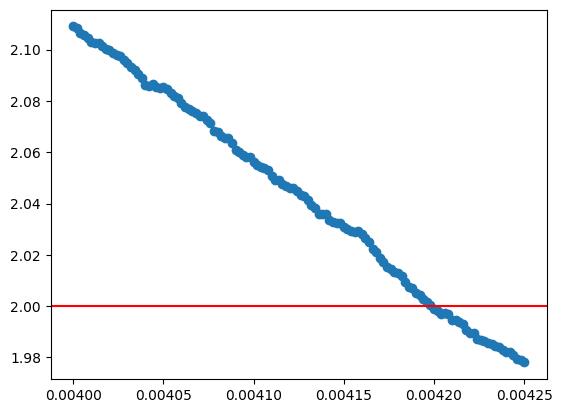

In [126]:
plt.scatter(lam_range, cost_means)
plt.axhline(2, c='red')

In [127]:
cost_means_df = pd.DataFrame()
cost_means_df.index = lam_range
cost_means_df['cost_mean'] = cost_means
cost_means_df['closest'] = (cost_means_df['cost_mean'] - 2).abs()
cost_means_df.sort_values('closest')
best_lambda = float(cost_means_df['closest'].idxmin())

In [128]:
best_lambda

0.004198000000000026

In [129]:
positive_we_mask = calculate_delta_we(u_a, p_a, best_lambda) > 0
calculate_cost_mean(lambda_df_split_a, positive_we_mask)

np.float64(2.000621924187015)

In [130]:
u_b = lambda_df_split_b['win_prob_u']
p_b = lambda_df_split_b['incorrect_call_prob']

positive_we_mask = calculate_delta_we(u_b, p_b, 0.004234000000000031) > 0
calculate_cost_mean(lambda_df_split_b, positive_we_mask)

np.float64(2.011975138795545)

In [131]:
merged_final['delta_we'] = calculate_delta_we(u, p, best_lambda)
merged_final['challenge'] = merged_final['delta_we'] > 0

In [132]:
def calculate_challenge_accuracy(df, delta_we_series):
    df = df.copy()
    df['delta_we'] = delta_we_series
    df['challenge'] = df['delta_we'] > 0
    acc = df.loc[df['challenge'], 'incorrect'].mean()
    return acc

In [133]:
test_df = merged_final[['incorrect']].copy()
accs = list()
lam_range = np.arange(.01, .08, .00001)
for lam in lam_range:
    acc = calculate_challenge_accuracy(test_df, calculate_delta_we(u, p, lam))
    accs.append(acc)


In [134]:
len(lam_range) * (.4/101)

27.722772277227723

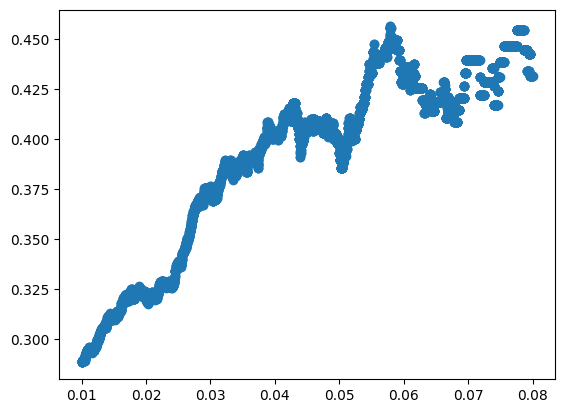

In [135]:
plt.scatter(lam_range, accs)

In [136]:
chal_accs = pd.DataFrame()
chal_accs.index = lam_range
chal_accs['accuracy'] = accs

In [137]:
chal_accs['accuracy'].idxmax()

np.float64(0.05780999999999805)

In [138]:
l = chal_accs['accuracy'].idxmax()
# l = .00666
max_acc = calculate_delta_we(u, p, l)
calculate_cost_mean(lambda_df, max_acc > 0)

np.float64(0.6569761057694753)

In [139]:
calculate_challenge_accuracy(lambda_df, max_acc)

np.float64(0.45614035087719296)

In [140]:
merged_final.groupby(['inning'])['challenge'].mean().sort_values(ascending=False)

inning
11    0.270942
10    0.247043
13    0.222222
12    0.168142
1     0.075151
4     0.055996
2     0.054198
3     0.054179
6     0.052657
5     0.050151
7     0.043862
8     0.039842
9     0.035793
Name: challenge, dtype: float64

In [141]:
# 1) sample sizes & rates
rate_by_inning = (merged_final
    .assign(challenge=lambda d: d['delta_we'] > 0)
    .groupby('inning')
    .agg(ch_rate=('challenge','mean'),
         n=('challenge','size'))
    .sort_values('ch_rate', ascending=False))
print(rate_by_inning)

# 2) leverage vs confidence by inning
lev_conf = merged_final.groupby('inning').agg(
    tu_mean=('win_prob_u','mean'),
    tu_p90 =('win_prob_u', lambda s: s.quantile(0.90)),
    p_mean =('incorrect_call_prob','mean'),
    p_p90  =('incorrect_call_prob', lambda s: s.quantile(0.90)),
    n      =('win_prob_u','size')
).sort_index()
print(lev_conf)

# 3) per-half budget actually spent
def half_budget(g):
    m = g['delta_we'] > 0
    return (1 - g.loc[m, 'incorrect_call_prob']).sum()

budget = (merged_final
          .groupby(['game_pk','inning_topbot'])
          .apply(half_budget, include_groups=False))
print({
    'mean_budget': budget.mean(),
    'median_budget': budget.median(),
    'p75': budget.quantile(.75),
    'p90': budget.quantile(.90)
})

# 4) Collapse extras for a cleaner view
merged_final['inning_bucket'] = merged_final['inning'].where(merged_final['inning']<=9, 10)
summary = (merged_final
    .assign(challenge=lambda d: d['delta_we'] > 0)
    .groupby('inning_bucket')
    .agg(ch_rate=('challenge','mean'),
         n=('challenge','size')))
print(summary)


         ch_rate      n
inning                 
11      0.270942    764
10      0.247043   2198
13      0.222222     27
12      0.168142    113
1       0.075151  35342
4       0.055996  32645
2       0.054198  34005
3       0.054179  34109
6       0.052657  33557
5       0.050151  33439
7       0.043862  33742
8       0.039842  34336
9       0.035793  24837
         tu_mean    tu_p90    p_mean     p_p90      n
inning                                               
1       0.018419  0.033162  0.074841  0.167882  35342
2       0.016586  0.030827  0.071724  0.147401  34005
3       0.015408  0.028911  0.074864  0.164840  34109
4       0.015926  0.030306  0.072880  0.154041  32645
5       0.014968  0.028336  0.071599  0.161743  33439
6       0.015222  0.031943  0.072000  0.156759  33557
7       0.012218  0.026824  0.074704  0.164840  33742
8       0.011401  0.027724  0.075570  0.165214  34336
9       0.010895  0.025284  0.074146  0.162156  24837
10      0.050894  0.108624  0.076196  0.162757

(array([5.4655e+04, 1.2619e+04, 4.3250e+03, 2.2920e+03, 6.4400e+02,
        1.3200e+02, 5.3000e+01, 3.8000e+01, 2.0000e+01, 1.0000e+00]),
 array([0.        , 0.08076087, 0.16152174, 0.24228261, 0.32304348,
        0.40380435, 0.48456522, 0.56532609, 0.64608696, 0.72684782,
        0.80760869]),
 <BarContainer object of 10 artists>)

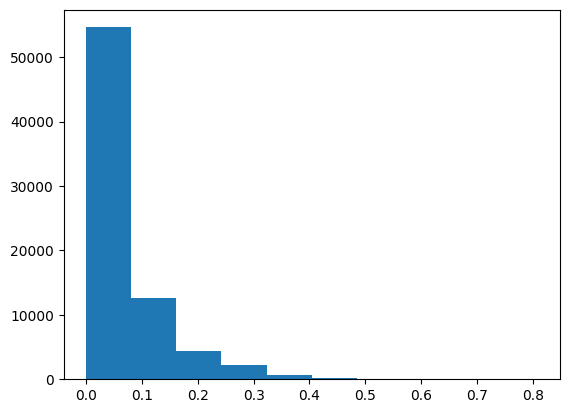

In [142]:
plt.hist(probs_cal)

In [143]:
X_test[
    (X_test['ump_id']==594151) &
    (X_test['inning']==7) &
    (X_test['zone']==1)
]

,ump_id,pitch_type,count,zone,inning,outs_when_up,pitcher_is_rhand,batter_is_rhand,sz_top,sz_bot
75395,594151,FF,0-0,1,7,0,True,True,3.44,1.69
59263,594151,FF,0-1,1,7,0,True,True,3.88,1.79
59246,594151,SI,0-0,1,7,0,True,True,3.22,1.28


(array([ 7599., 15531., 18350., 15244.,  7089.,  3892.,  3112.,  2194.,
         1403.,   365.]),
 array([0.00109836, 0.09089158, 0.1806848 , 0.27047804, 0.36027125,
        0.45006445, 0.53985769, 0.62965089, 0.7194441 , 0.8092373 ,
        0.89903057]),
 <BarContainer object of 10 artists>)

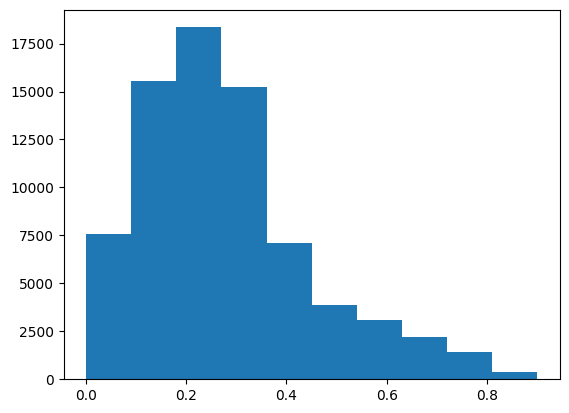

In [144]:
plt.hist(probs)

In [145]:
(probs_cal<.005).mean()

np.float64(0.05280894368739887)

In [146]:
probs_cal.std()

np.float64(0.06887566485227743)

In [147]:
td = statcast('2025-08-27')

This is a large query, it may take a moment to complete


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


In [148]:
tdc, tump = choice_df_maker(td)
tdc = choice_df_preproc(tdc)

In [149]:
missed_call_model.predict_proba(tdc[tdc['ump_id'].isin(X_test['ump_id'].unique())][feature_cols])

array([[0.8749446 , 0.12505536],
       [0.4348644 , 0.5651356 ],
       [0.85756975, 0.14243025],
       ...,
       [0.6405953 , 0.35940465],
       [0.50794774, 0.49205226],
       [0.82181007, 0.17818992]], shape=(2188, 2), dtype=float32)

In [150]:
X_test.dtypes

ump_id                int64
pitch_type           object
count                object
zone                  int64
inning                int64
outs_when_up          int64
pitcher_is_rhand     object
batter_is_rhand      object
sz_top              float64
sz_bot              float64
dtype: object

In [151]:
tdc['sz_bot'].astype(float)

4131    1.48
4249    1.42
3634    1.55
3098    1.29
3208    1.34
        ... 
3436    1.37
3561    1.36
3809    1.58
3928    1.47
4160    1.57
Name: sz_bot, Length: 2188, dtype: float64

In [152]:
(missed_call_model.predict_proba(tdc[feature_cols])[:, 1])

array([0.12505536, 0.5651356 , 0.14243025, ..., 0.35940465, 0.49205226,
       0.17818992], shape=(2188,), dtype=float32)

In [153]:
X_test.assign(probs = probs).groupby('ump_id')['probs'].mean()#.idxmin()

ump_id
427013    0.272189
427044    0.290698
427093    0.274328
427113    0.290521
427129    0.315224
            ...   
665576    0.283520
668921    0.280832
676580    0.272374
676581    0.261885
691042    0.274750
Name: probs, Length: 87, dtype: float32

In [154]:
td.loc[[3737]]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
3737,CH,2025-08-27,88.5,3.53,5.39,"Lodolo, Nick",605141,666157,field_out,hit_into_play,...,2,2.9,1.33,-1.33,16.1,6.35248,-1.665164,32.654868,43.619346,35.044707


In [155]:
ff = statcast('2025-08-29')

This is a large query, it may take a moment to complete


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


In [156]:
ffc, fump = choice_df_maker(ff)
ffc = choice_df_preproc(ffc)
ffc['real'] = ffc.apply(ball_or_strike, axis=1)
ffc['correct'] = ffc['call'] == ffc['real']

In [157]:
ffc

,game_date,ump_name,player_name,ump_id,pitch_type,pitcher_is_rhand,inning,count,outs_when_up,pitcher,...,batter_is_rhand,plate_x,plate_z,sz_top,sz_bot,zone,call,real,correct,incorrect
3322,2025-08-29,Alfonso Márquez,"Duran, Jhoan",427315,FF,True,9,1-2,2,661395,...,False,-0.84,5.03,3.53,1.75,11,ball,ball,True,False
3556,2025-08-29,Alfonso Márquez,"Duran, Jhoan",427315,FS,True,9,1-0,2,661395,...,False,-0.66,2.68,3.62,1.77,4,strike,strike,True,False
3701,2025-08-29,Alfonso Márquez,"Duran, Jhoan",427315,KC,True,9,0-0,2,661395,...,False,-0.12,0.66,3.59,1.80,13,ball,ball,True,False
3965,2025-08-29,Alfonso Márquez,"Duran, Jhoan",427315,FS,True,9,2-1,1,661395,...,False,-0.06,3.0,3.39,1.63,2,strike,strike,True,False
4088,2025-08-29,Alfonso Márquez,"Duran, Jhoan",427315,FF,True,9,1-1,1,661395,...,False,-0.8,3.79,3.44,1.62,11,ball,ball,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,2025-08-29,Brian Walsh,"Ray, Robbie",665281,FF,False,1,3-2,0,592662,...,False,-0.96,3.56,3.32,1.60,11,ball,ball,True,False
4140,2025-08-29,Brian Walsh,"Ray, Robbie",665281,FF,False,1,3-0,0,592662,...,False,0.02,3.34,3.32,1.60,2,strike,strike,True,False
4283,2025-08-29,Brian Walsh,"Ray, Robbie",665281,FF,False,1,2-0,0,592662,...,False,-0.64,3.51,3.36,1.60,11,ball,ball,True,False
4528,2025-08-29,Brian Walsh,"Ray, Robbie",665281,FF,False,1,1-0,0,592662,...,False,-1.1,3.08,3.37,1.60,11,ball,ball,True,False


In [158]:
ffc[
    (ffc['player_name']=='Gallen, Zac') & (ffc['batter']==518692)
]

,game_date,ump_name,player_name,ump_id,pitch_type,pitcher_is_rhand,inning,count,outs_when_up,pitcher,...,batter_is_rhand,plate_x,plate_z,sz_top,sz_bot,zone,call,real,correct,incorrect
57,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,KC,True,6,3-2,2,668678,...,False,0.29,0.91,3.68,1.73,14,ball,ball,True,False
87,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,CH,True,6,2-1,2,668678,...,False,-0.79,1.49,3.67,1.77,13,strike,ball,False,True
107,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,CH,True,6,1-1,2,668678,...,False,-1.41,1.13,3.66,1.75,13,ball,ball,True,False
132,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,FF,True,6,0-1,2,668678,...,False,-1.17,2.11,3.69,1.81,13,ball,ball,True,False
943,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,FF,True,4,0-1,0,668678,...,False,-0.94,2.01,3.72,1.85,13,strike,ball,False,True
993,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,FF,True,4,0-0,0,668678,...,False,-0.68,3.15,3.59,1.74,1,strike,strike,True,False
2937,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,KC,True,1,2-1,2,668678,...,False,0.48,1.75,3.65,1.67,9,strike,strike,True,False
3049,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,CH,True,1,1-1,2,668678,...,False,0.53,0.9,3.66,1.71,14,ball,ball,True,False
3147,2025-08-29,Phil Cuzzi,"Gallen, Zac",427093,FF,True,1,0-1,2,668678,...,False,0.4,0.94,3.66,1.71,14,ball,ball,True,False


In [159]:
zz = ffc.loc[[102]].copy()
zz.loc[:, 'zone'] = 7
zz

,game_date,ump_name,player_name,ump_id,pitch_type,pitcher_is_rhand,inning,count,outs_when_up,pitcher,...,batter_is_rhand,plate_x,plate_z,sz_top,sz_bot,zone,call,real,correct,incorrect
102,2025-08-29,Nate Tomlinson,"Kirby, George",608158,KC,True,7,1-1,1,669923,...,False,0.28,0.79,3.77,1.65,7,ball,ball,True,False


In [160]:
missed_call_model.predict_proba(zz[feature_cols])

array([[0.6538012 , 0.34619877]], dtype=float32)

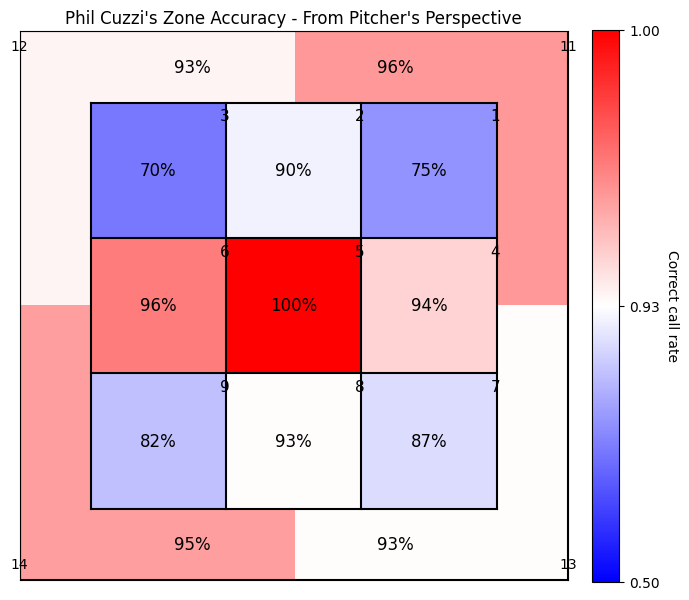

In [162]:
make_ump_heatmap(ump_zone_acc, 427093)